In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
# VADER is stored separately in NLTK's data directory. Download the first time using.
# nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

sns.set(style="whitegrid")

In [48]:
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


# Inspect and Preprocessing

In [52]:
print('Dataset Info:')
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
None


In [50]:
print('Missing Values:')
df.isnull().sum()

Missing Values:


show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [53]:
# Drop rows with missing essential columns (title, type)
df.dropna(subset=['title', 'type', 'date_added'], inplace=True)

# Fill missing values in columns like 'director', 'cast', or 'rating' if appropriate
df.fillna({'director' :'Unknown'}, inplace=True)
df.fillna({'cast':'Unknown'}, inplace=True)
df.fillna({'country':'Unknown'}, inplace=True)
df.fillna({'rating':'Not Rated'}, inplace=True)
df.fillna({'duration':'Not Rated'}, inplace=True)

# Convert to date_added to datetime 
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.year

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,2021.0
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,2021.0
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0,2021.0
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021.0,2021.0
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021.0,2021.0


# Feature Engineering

In [54]:
df['content_age'] = 2025 - df['release_year']  # Current Year: 2025
df['primary_genre'] = df['listed_in'].apply(lambda x: x.split(',')[0])

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,content_age,primary_genre
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,2021.0,5,Documentaries
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,2021.0,4,International TV Shows
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0,2021.0,4,Crime TV Shows
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021.0,2021.0,4,Docuseries
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021.0,2021.0,4,International TV Shows


# Exploratory Data Analysis

## Movies vs. TV Shows 

In [29]:
df['type'].value_counts()

type
Movie      6131
TV Show    2676
Name: count, dtype: int64

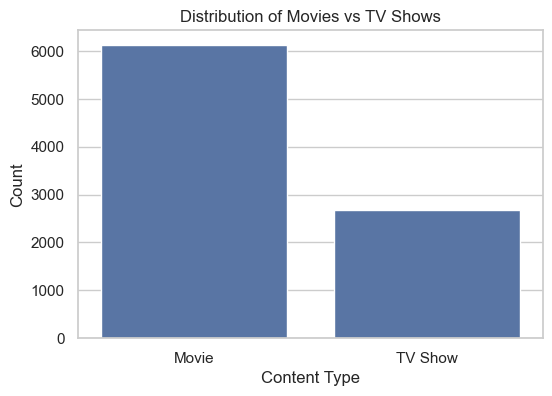

In [32]:
plt.figure(figsize=(6,4))
sns.countplot(x='type', data=df)
plt.title('Distribution of Movies vs TV Shows')
plt.xlabel('Content Type')
plt.ylabel('Count')
plt.show()

## Content Added Over Time

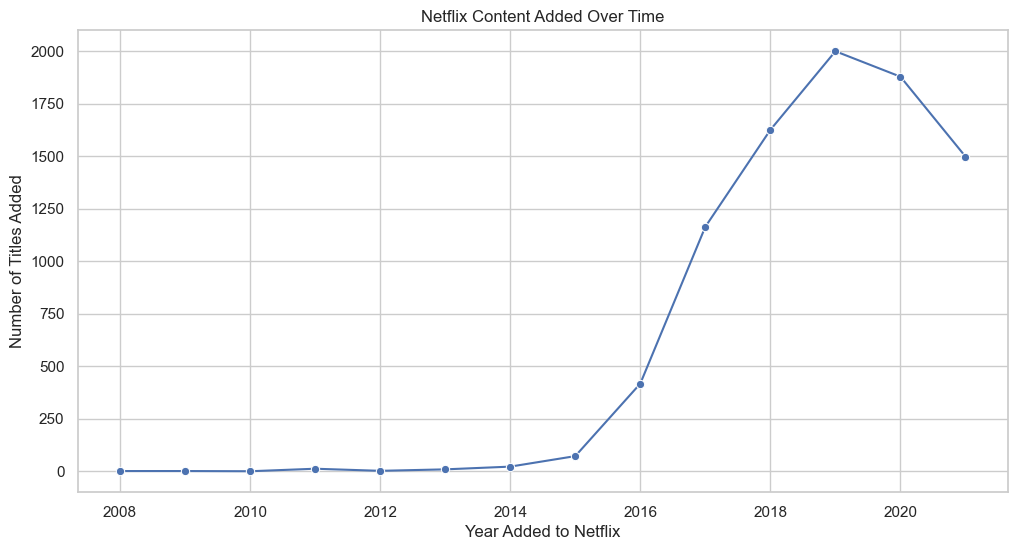

In [62]:
content_over_time = df['year_added'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=content_over_time.index, y=content_over_time.values, marker='o')
plt.title('Netflix Content Added Over Time')
plt.xlabel('Year Added to Netflix')
plt.ylabel('Number of Titles Added')
plt.grid(True)
plt.show()

## Top 10 Countries Producing Content

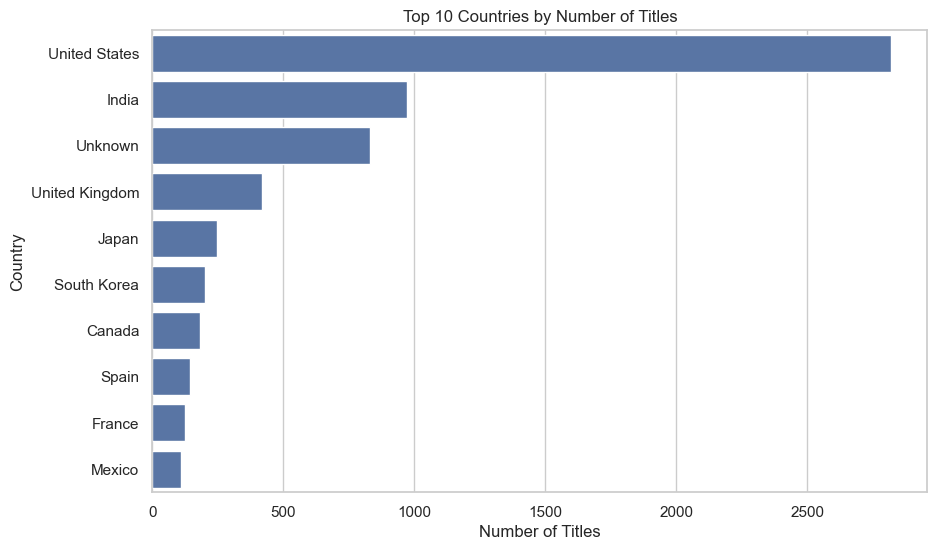

In [35]:
top_countries = df['country'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries by Number of Titles')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.show()

## Content Rating Distribution

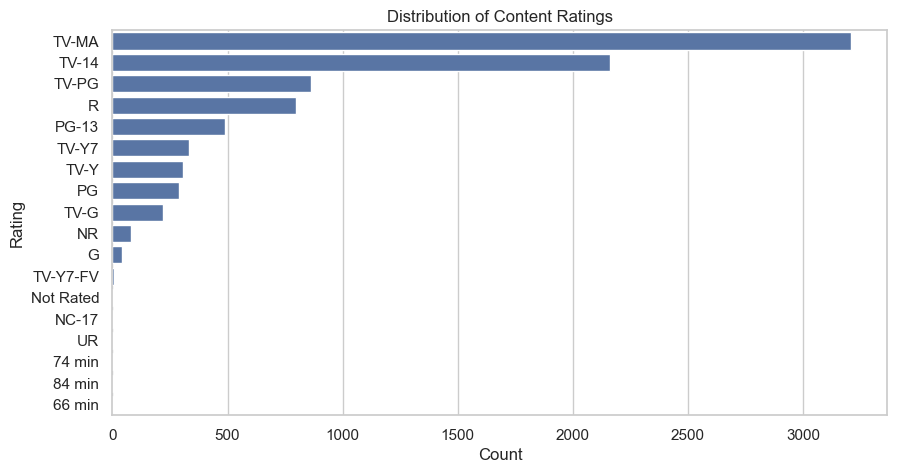

In [37]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='rating', order=df['rating'].value_counts().index)
plt.title('Distribution of Content Ratings')
plt.xlabel('Count')
plt.ylabel('Rating')
plt.show()

## Duration Analysis

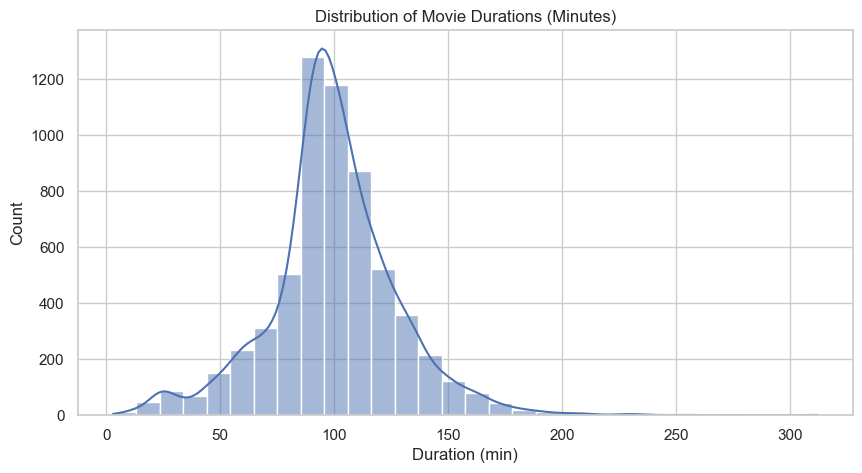

In [63]:
movies = df[df['type'] == 'Movie'].copy()
movies['duration'] = movies['duration'].str.extract(r'(\d+)').astype(float)

plt.figure(figsize=(10, 5))
sns.histplot(movies['duration'], bins=30, kde=True)
plt.title('Distribution of Movie Durations (Minutes)')
plt.xlabel('Duration (min)')
plt.ylabel('Count')
plt.show()

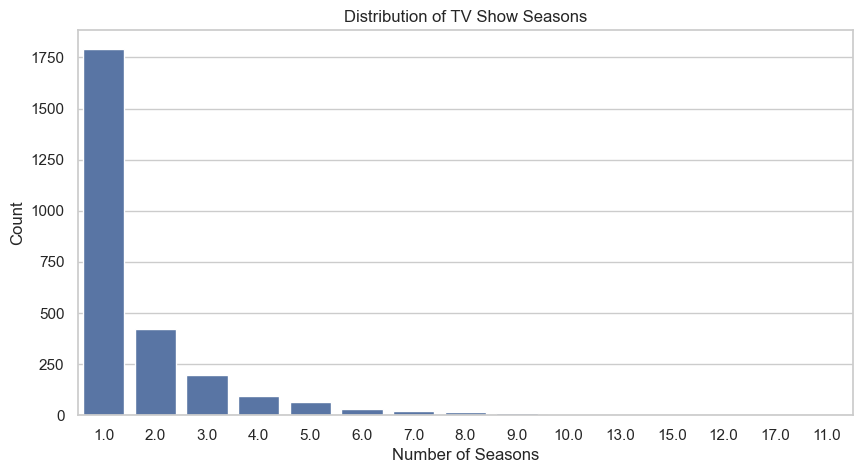

In [61]:
tv_shows = df[df['type'] == 'TV Show'].copy()
tv_shows['duration'] = tv_shows['duration'].str.extract(r'(\d+)').astype(float)

plt.figure(figsize=(10, 5))
sns.countplot(x='duration', data=tv_shows, order=tv_shows['duration'].value_counts().index)
plt.title('Distribution of TV Show Seasons')
plt.xlabel('Number of Seasons')
plt.ylabel('Count')
plt.show()

## Top 10 Most Common Genres

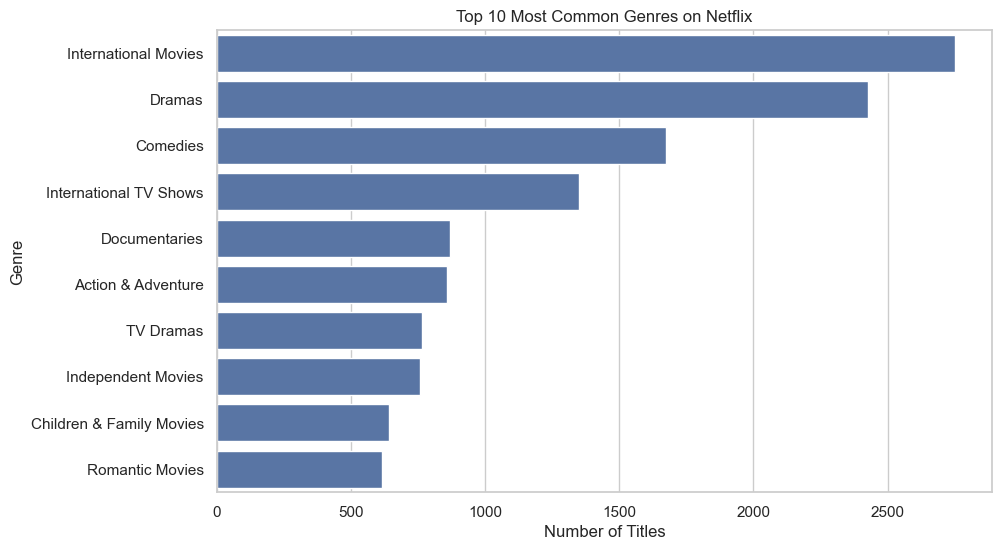

In [44]:
# Split multiple genres per title (optional)
df['genre_split'] = df['listed_in'].str.split(', ')

# Flatten genre list and count
genre_flat = [genre for sublist in df['genre_split'].dropna() for genre in sublist]
genre_count = Counter(genre_flat).most_common(10)

# Convert to DataFrame
genre_df = pd.DataFrame(genre_count, columns=['Genre', 'Count'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Genre', data=genre_df)
plt.title('Top 10 Most Common Genres on Netflix')
plt.xlabel('Number of Titles')
plt.ylabel('Genre')
plt.show()

# Sentiment Analysis on Descriptions

Sentiment scores:
- Negative: -1 to -0.05
- Neutral: -0.05 to +0.05
- Positive: +0.05 to +1

In [69]:
# Split genres into individual rows (explode the dataset)
df_genres = df.assign(genre=df['listed_in'].str.split(', ')).explode('genre')

# Clean genre names (remove leading/trailing spaces)
df_genres['genre'] = df_genres['genre'].str.strip()

# Get top 15 most common genres for analysis
top_genres = df_genres['genre'].value_counts().head(15).index
df_top_genres = df_genres[df_genres['genre'].isin(top_genres)]

### Visualizing Sentiment by Genre

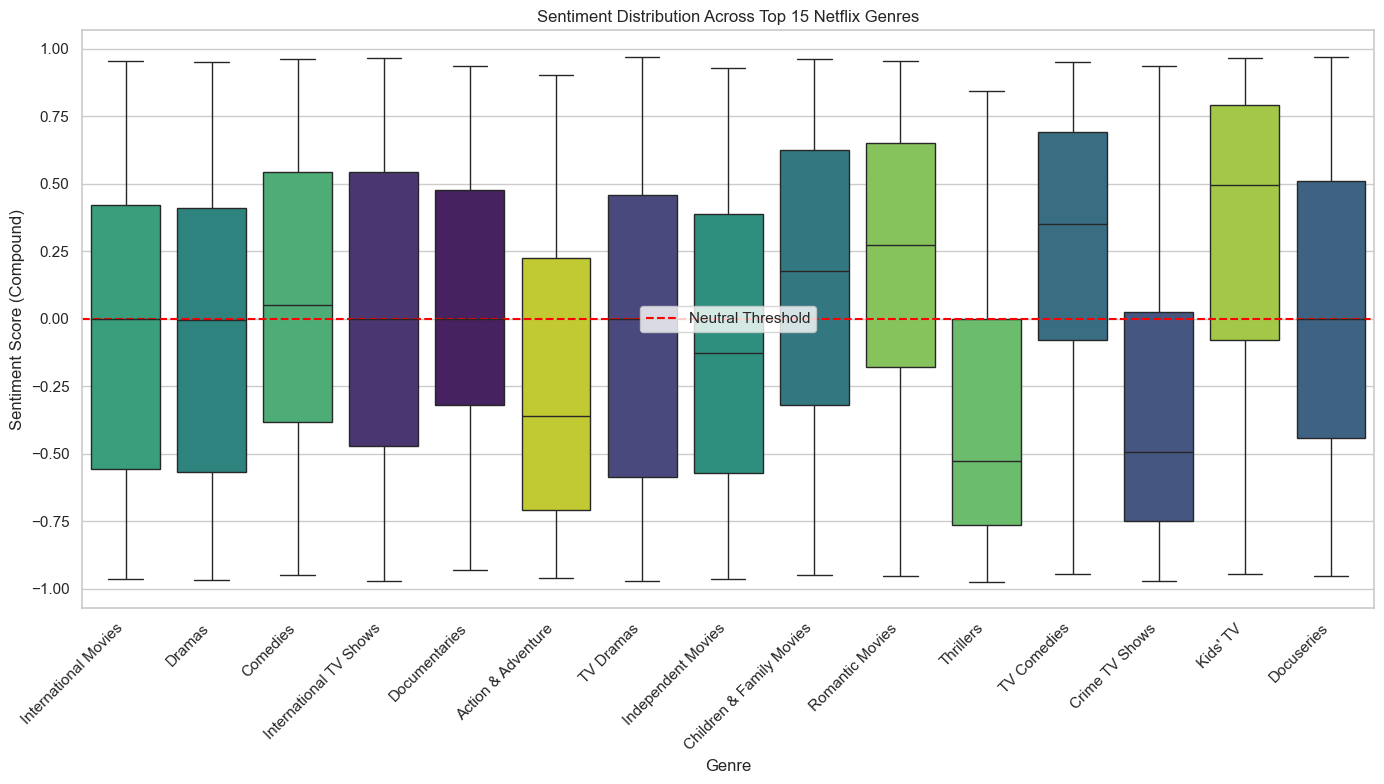

In [76]:
plt.figure(figsize=(14, 8))
sns.boxplot(
    x='genre',
    hue='genre',
    y='sentiment',
    data=df_top_genres,
    order=top_genres,
    palette='viridis',
    legend=False
)
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='red', linestyle='--', label='Neutral Threshold')
plt.title('Sentiment Distribution Across Top 15 Netflix Genres')
plt.ylabel('Sentiment Score (Compound)')
plt.xlabel('Genre')
plt.legend()
plt.tight_layout()
plt.show()

Key Observations:
- Children and Family Movies, Romantic Movies, TV Comedies and Kid's TV have the highest positive sentiment.
- Action and Adventure, Thrillers and Crime TV Show negative-leaning sentiment.
- International Movies, Dramas, Documentaries and Docuseries tend to be neutral.

### Genre vs Sentiment Intensity

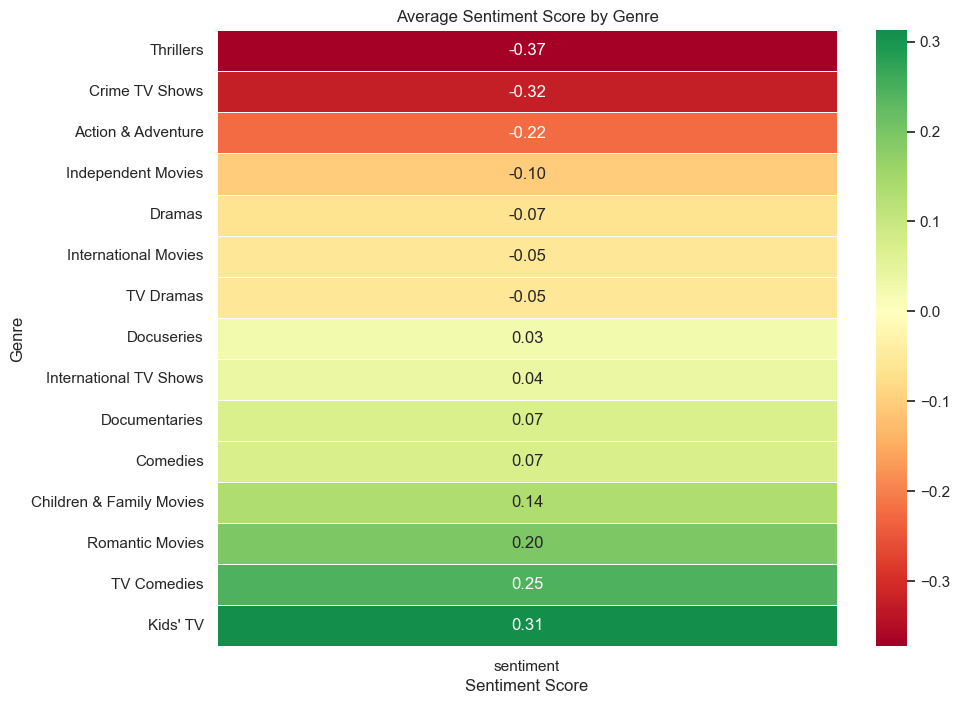

In [77]:
genre_sentiment = df_top_genres.groupby('genre')['sentiment'].mean().sort_values()

plt.figure(figsize=(10, 8))
sns.heatmap(
    genre_sentiment.to_frame(),
    annot=True,
    cmap='RdYlGn',
    center=0,
    fmt='.2f',
    linewidths=0.5
)
plt.title('Average Sentiment Score by Genre')
plt.ylabel('Genre')
plt.xlabel('Sentiment Score')
plt.show()

# Basic Content-based Recommendation

In [ ]:
## Recommend based on genres

## Recommend based on genres

In [80]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['listed_in'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def recommend_content(title, cosine_sim=cosine_sim):
    idx = df[df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # Top 5 recommendations
    movie_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[movie_indices]

# Example: Get recommendations for "Stranger Things"
print("\nRecommendations for 'Stranger Things':")
print(recommend_content('Stranger Things'))


Recommendations for 'Stranger Things':
3187        Nightflyers
3685    Stranger Things
6953              Helix
241            Manifest
3986             The OA
Name: title, dtype: object


## Recommend Similar Directors Based on Sentiment Profile

In [85]:
# Clean director data and explode multiple directors
df_directors = df.assign(director=df['director'].str.split(', ')).explode('director')
df_directors = df_directors[df_directors['director'] != 'No Director']

# Calculate average sentiment per director (min 5 works)
director_stats = (
    df_directors.groupby('director')
    .agg(
        avg_sentiment=('sentiment', 'mean'),
        count=('show_id', 'count'),
        genres=('listed_in', lambda x: ', '.join(set(', '.join(x).split(', '))))
    )
    .query('count >= 5')  # Only directors with ≥5 works
    .sort_values('avg_sentiment', ascending=False)
)

In [91]:
def recommend_by_mood(director_name, desired_sentiment='positive'):
    director_sentiment = director_stats.loc[director_name, 'avg_sentiment']
    
    if desired_sentiment == 'positive':
        candidates = director_stats[director_stats['avg_sentiment'] > director_sentiment].copy()
    else:
        candidates = director_stats[director_stats['avg_sentiment'] < director_sentiment].copy()
    
    # Find directors with genre overlap
    target_genres = set(director_stats.loc[director_name, 'genres'].split(', '))
    candidates.loc[:, 'genre_overlap'] = candidates['genres'].apply(
        lambda x: len(set(x.split(', ')) & target_genres)
    )
    
    return candidates.sort_values(['genre_overlap', 'avg_sentiment'], ascending=False).head(5)

# Example: Get recommendations for a similar directors to David Fincher
print("\nRecommendations for directors similar to 'David Fincher':")
print(recommend_by_mood('David Fincher', 'positive')[['avg_sentiment', 'genres']])


Recommendations for directors similar to 'David Fincher':
                  avg_sentiment  \
director                          
Vishal Bhardwaj        0.337560   
Unknown                0.109869   
Nagesh Kukunoor        0.020440   
Dibakar Banerjee      -0.054257   
Kevin Smith           -0.102633   

                                                             genres  
director                                                             
Vishal Bhardwaj   Thrillers, International Movies, Romantic Movi...  
Unknown           TV Sci-Fi & Fantasy, Classic & Cult TV, Sports...  
Nagesh Kukunoor   Thrillers, International Movies, Comedies, Dra...  
Dibakar Banerjee  Thrillers, International Movies, Comedies, Hor...  
Kevin Smith       Romantic Movies, Comedies, Dramas, Horror Movi...  
